In [1]:
import pynbody
import numpy as np
import matplotlib.pyplot as plt

In [2]:
datadir = '/home/pdcg/Documents/post_process_routines/'
gsl_solver = 'lvl5_initsize_noevo/'
s = pynbody.load(datadir+gsl_solver+'snapdir_127/snapshot_127')

/home/pdcg/anaconda3/lib/python3.9/site-packages/pynbody/snapshot/gadgethdf.py:370: UserWarning: Masses are either stored in the header or have another dataset name; assuming the cosmological factor h**-1
  warnings.warn("Masses are either stored in the header or have another dataset name; assuming the cosmological factor %s" % units.h**-1)


In [3]:
G = 6.674e-8 # In cgs cm3 s-2 g-1
kpc = 3.09e21 # in cm
msun = 1.989e33 # in g
gyr = 3.15576e16 # in s
s['eps'] = s['smooth']
for key in s.families():
  s[key]['eps'] = s[key]['eps'].min()
s.physical_units()

In [4]:
h = s.halos()
h1_tf = pynbody.analysis.angmom.faceon(h[0])

In [5]:
s['Tij'] = s['TIJ_Eigenvalues'] * gyr**2
s['T'] = s['Tij_x'] + 1/3*np.abs(s['Tij_x'] + s['Tij_y'] + s['Tij_z'])

In [6]:
p = pynbody.analysis.profile.Profile(h[0].s, min=0.01, max= 50, ndim=3)

In [7]:
mask = (h[0].s['age'].in_units('Gyr')<1) * (h[0].s['InitialMassFractionInClusters']>0.)

/home/pdcg/anaconda3/lib/python3.9/site-packages/pynbody/analysis/cosmology.py:182: RuntimeWarning: invalid value encountered in log
  log_a_input = np.log(1./(1.+z))


In [8]:
circ_vel_est = np.sqrt(1/3 * np.abs(h[0].s['Tij_x'] + h[0].s['Tij_y'] + h[0].s['Tij_z']))
kappa_est = np.sqrt(np.abs(3*circ_vel_est**2 - h[0].s['Tij_x']))

pynbody.analysis.profile : Profile v_circ -- this routine assumes the disk is in the x-y plane


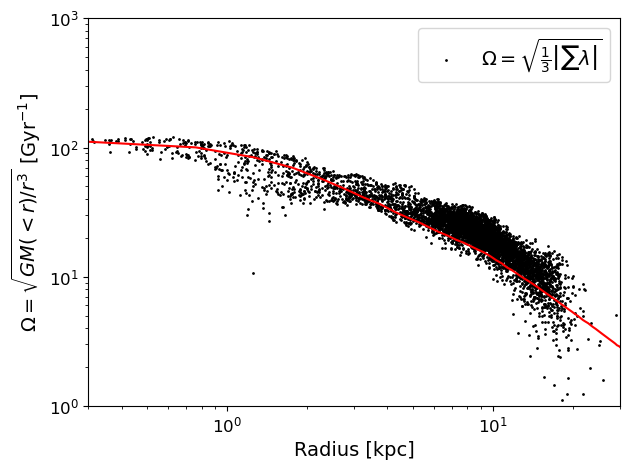

In [9]:
plt.loglog(p['rbins'], p['omega'], c='r')
plt.scatter(h[0].s['r'][mask], circ_vel_est[mask], s=1, c='k', label=r'$\Omega = \sqrt{\frac{1}{3}\left| \sum{\lambda}\right|}$')
plt.xlim(3e-1, 3e1)
plt.ylim(1e0, 1e3)
plt.legend(fontsize=14)
plt.xlabel("Radius [kpc]", fontsize=14)
plt.ylabel(r"$\Omega = \sqrt{GM(<r)/r^3}$ [Gyr$^{-1}$]", fontsize=14)
plt.tick_params(labelsize=12)
plt.tight_layout()
plt.savefig('circvel_tidal.png')

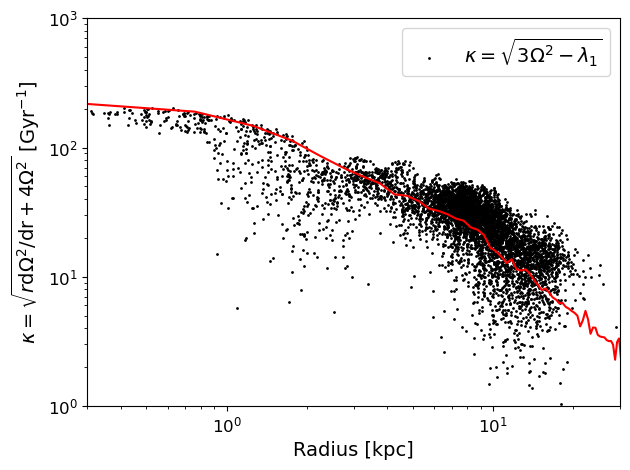

In [10]:
plt.scatter(h[0].s['r'][mask], kappa_est[mask], s=1, c='k', label=r'$\kappa = \sqrt{3\Omega^2 - \lambda_1}$')
plt.loglog(p['rbins'], p['kappa'], c='r')
plt.xlim(3e-1,3e1)
plt.ylim(1e0,1e3)
plt.legend(fontsize=14)
plt.xlabel("Radius [kpc]", fontsize=14)
plt.ylabel(r"$\kappa = \sqrt{r \rm{d}\Omega^2/\rm{d}r + 4\Omega^2}$ [Gyr$^{-1}$]", fontsize=14)
plt.tick_params(labelsize=12)
plt.tight_layout()
plt.savefig('epyciclic_tidal.png')

In [32]:
dens_prof_est = np.abs(h[0].s['Tij_x'] + h[0].s['Tij_y'] + h[0].s['Tij_z'])/(4 * np.pi * G * gyr**2)
dens_prof_est *= (kpc**3)/(msun)

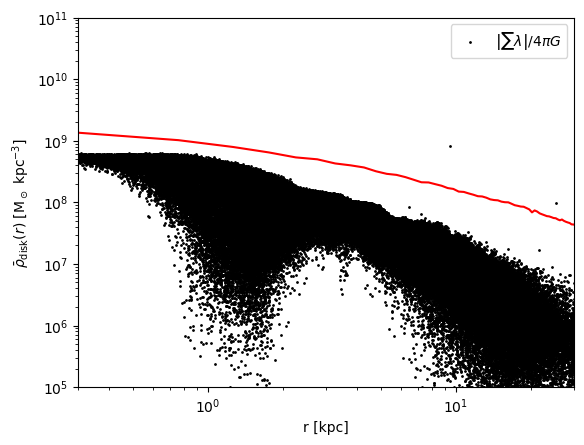

In [33]:
plt.plot(p['rbins'], p['density'], c='r')
plt.scatter(h[0].s['r'], dens_prof_est, s=1, c='k', label=r'$\left| \sum{\lambda}\right| / 4 \pi G$')
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e5, 1e11)
plt.xlim(3e-1, 3e1)
plt.xlabel("r [kpc]")
plt.ylabel(r"$\bar{\rho}_\mathrm{disk} (r)$ [M$_\odot$ kpc$^{-3}$]")
plt.legend()
# plt.savefig('avedens_tidal.png')